### Задание №3

* Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить:
    * Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф";
    * Cохранить ее в pandas dataframe, а также в excel, pickle, БД;
    * Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных;
    * Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [1]:
import requests

import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
class CollectData:
    """Class for collecting data from the site and saving it in the selected format."""
    
    def __init__(self, count=1, path='./', output_format='excel'):
        self._count = count
        self._path = path
        self._output_format = output_format
        self.data = []
        self._offset = 0
        
    
    def get_data(self):
        """Function for receiving data from the site and forming a Pandas.Dataframe."""
        
        offset_ = self._offset
        limit_ = 10
        res_id = []
        count = 0
        
        while count <= self._count: 
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            temp = requests.get(url).json().get('data').get('list')
            count += len(temp)
    
            if len(temp):        
                obj_ids = [x.get('objId') for x in temp]
                res_id += obj_ids
                offset_ += limit_
            else:
                print('Uploaded: ' + str(offset_) + ' records!')
                break
        
    
        obj_list = []
        for obj_id in tqdm(res_id):
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{obj_id}'
            x = requests.get(url).json().get('data')
            obj_list.append(x)


        dataframe = pd.concat([pd.json_normalize(i) for i in obj_list], ignore_index=True)
        self.data = dataframe


    def saving_data(self, *output_format):
        """Function to save data in the selected format."""
        
        if self._output_format == 'excel':
            self.data.to_excel(self._path + 'domrf.xlsx')
            print('Saved data to ' + self._output_format)

        elif self._output_format =='pickle':
            self.data.to_pickle(self._path + 'domrf.pkl')
            print('Saved data to ' + self._output_format)

        elif self._output_format =='db':
            conn = sqlite3.connect( self._path + 'domrf.db')
            self.data.to_sql('domrf_main', conn , if_exists='replace')
            print('Saved data to ' + self._output_format)
            conn.commit()
            conn.close()
        else:
            raise ValueError ('No such type defined')

In [5]:
data = CollectData(count=1000, output_format='excel')

In [6]:
data.get_data()

100%|███████████████████████████████████████| 1010/1010 [04:03<00:00,  4.15it/s]


In [7]:
data.saving_data()

Saved data to excel


In [8]:
class CheckStatus:
    """Class for converting data into a form convenient for analysis."""
    
    def __init__(self, path):
        self._path = path

        
    def load(self):
        """Function to load data file."""
        
        if self._path == './domrf.xlsx':
            self._obj = pd.read_excel(self._path)

        elif self._path =='./domrf.pkl':
            self._obj = pd.read_pickle(self._path)
        
        else:
            raise ValueError('This file cannot be read')


    def get_columns(self):
        """Function to display possible columns in a dataframe."""
        
        print(self._obj.columns)

        
    def set_types(self):
        """Function to convert data types."""
        
        col_for_analize = ['region',
                    'objElemLivingCnt', 
                    'objReady100PercDt', 
                    'objElemParkingCnt',
                    'objSquareLiving', 
                    'objFlatCnt', 
                    'objFlatSq', 
                    'objFloorCnt', 
                    'soldOutPerc',
                    'objPriceAvg']
        
        df = pd.DataFrame(self._obj[col_for_analize])
        df.fillna(0, inplace = True)

        col_types = {'region' : 'int32' ,
             'objElemLivingCnt' : 'int32' ,
             'objReady100PercDt' : 'datetime64', 
             'objElemParkingCnt' : 'int32',
             'objSquareLiving' : 'float64', 
             'objFlatCnt' : 'int32', 
             'objFlatSq' : 'float64', 
             'objFloorCnt' : 'int32', 
             'soldOutPerc' : 'float64',
             'objPriceAvg' : 'float64'}
        
        df = df.astype(col_types)
        df['ready_year'] = df['objReady100PercDt'].apply(lambda x: x.year)
        df['avg_sqr'] = df['objFlatSq'] / df['objFlatCnt']
        
        self._obj = df


    def get_result(self):
        """Function to output transformations in a dataframe."""
        
        return (self._obj)

In [9]:
test = CheckStatus(path='./domrf.xlsx')

In [10]:
test.load()

In [11]:
test.get_columns()

Index(['Unnamed: 0', 'id', 'pdId', 'region', 'address', 'objElemLivingCnt',
       'objReady100PercDt', 'wallMaterialShortDesc', 'objLkFinishTypeDesc',
       'objLkFreePlanDesc',
       ...
       'developer.bankruptStage.bankruptStageDesc',
       'developer.bankruptStage.bankruptLawUrl',
       'developer.orgBankruptMsgDttm', 'metro.id', 'metro.name', 'metro.line',
       'metro.color', 'metro.time', 'metro.isWalk', 'metro.colors'],
      dtype='object', length=109)


In [12]:
test.set_types()

In [13]:
test.get_result()

,region,objElemLivingCnt,objReady100PercDt,objElemParkingCnt,objSquareLiving,objFlatCnt,objFlatSq,objFloorCnt,soldOutPerc,objPriceAvg,ready_year,avg_sqr
0,61,18,2020-03-31,0,1519.00,18,1519.00,0,0.000000,0.0,2020,84.388889
1,72,65,2024-12-31,0,6248.51,65,6248.51,12,0.999984,45523.0,2024,96.130923
2,72,43,2024-12-31,0,4812.98,43,4812.98,10,1.000000,47886.0,2024,111.929767
3,72,68,2022-12-31,31,6293.78,68,6293.78,20,0.407164,53109.0,2022,92.555588
4,72,44,2022-12-31,41,4297.44,44,4297.44,12,0.450622,55893.0,2022,97.669091
...,...,...,...,...,...,...,...,...,...,...,...,...
1005,46,137,2023-12-31,0,14291.60,137,14291.60,19,0.610071,64706.0,2023,104.318248
1006,46,0,2023-12-31,166,0.00,0,0.00,2,0.299867,69745.0,2023,NaN
1007,54,745,2024-12-31,299,41405.95,745,41405.95,29,0.000650,89035.0,2024,55.578456
1008,54,745,2026-12-31,299,41405.95,745,41405.95,29,0.000000,0.0,2026,55.578456


In [14]:
df = test.get_result()

In [27]:
class Visualization:
    """Class for data visualization."""
    
    def __init__(self, obj, by = 'region'):
        self._by = 'region'
        self._obj = obj

    def show_graph(self, by):
        """The function allows you to build a graph for data analysis."""
        
        df = self._obj
        df = df[df['objPriceAvg'] > 0]
        df['objPrice'] = df['objPriceAvg'] * df['objFlatSq']

        if by:
            self._by = by
        
        if by == 'region':
            by_region = df[['region','objFlatSq','objPrice']].groupby(['region']).aggregate({'objFlatSq' : 'sum', 'objPrice' : 'sum'})
            plt.rcParams.update({'figure.autolayout': True})
            fig, ax = plt.subplots(figsize = (8,12))
            for_bar = (by_region['objPrice'] / by_region['objFlatSq'])
            cat = [str(x) for x in for_bar.index]
            plt.barh(cat, sorted(for_bar.values), height=0.3)
            plt.title('Average property value by region')
            plt.xlabel('Price')
            plt.ylabel('Region')
            plt.show()

        elif by == 'year':
            by_year = df[['ready_year','objSquareLiving']].groupby(['ready_year']).agg('sum')
            plt.rcParams.update({'figure.autolayout': True})
            fig, ax = plt.subplots(figsize = (8,12))
            x_ticks = [str(x) for x in by_year.index]
            plt.bar(x_ticks, by_year['objSquareLiving'], color='g')
            plt.title('Entering real estate by years')
            plt.xlabel('Year')
            plt.ylabel('Quantity')
            plt.show()
        
        else:
            raise ValueError('Such a graph is currently impossible to construct')

In [28]:
vis = Visualization(df)

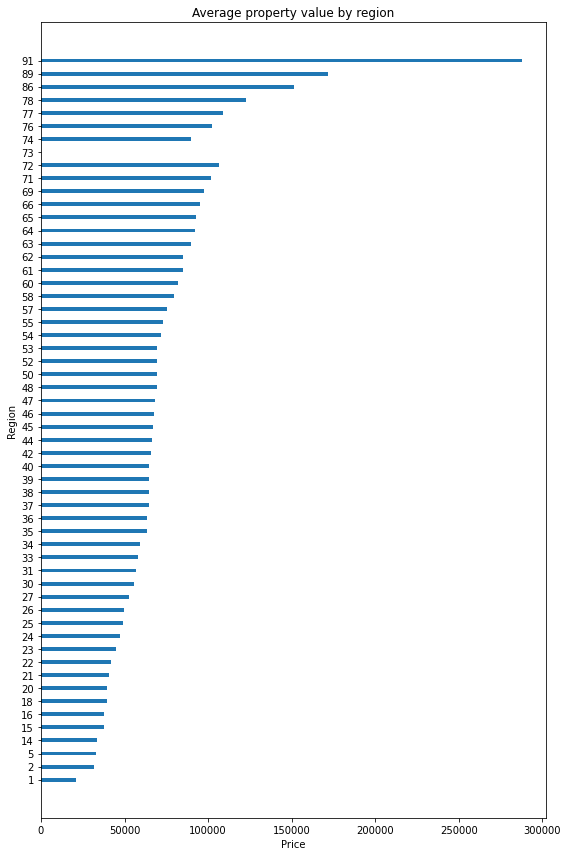

In [29]:
vis.show_graph('region')

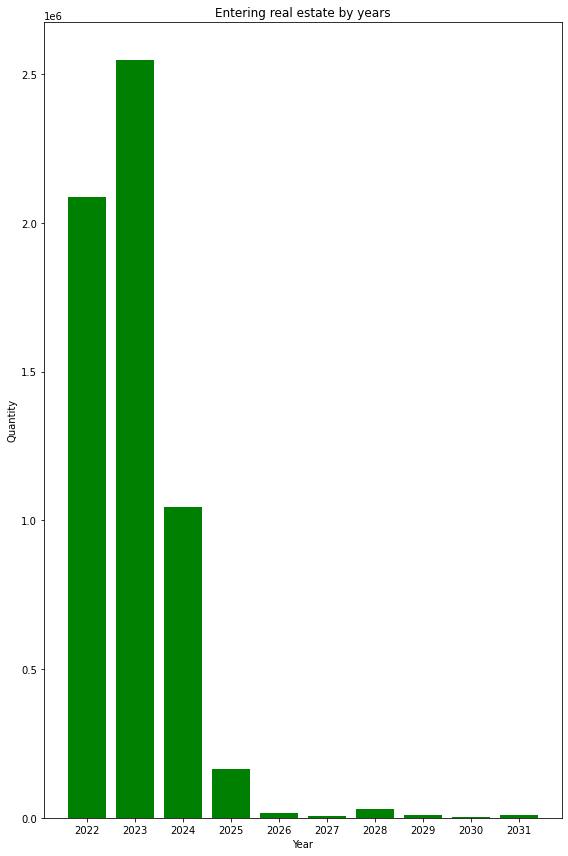

In [30]:
vis.show_graph('year')